In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

df = pd.read_csv('dataset_9.csv', low_memory=False)
df['eventDate'] = pd.to_datetime(df['eventDate'])
print(f"Loaded {len(df)} records.")
df.head()

Loaded 100000 records.


,gbifID,datasetKey,occurrenceID,kingdom,phylum,class,order,family,genus,species,...,identifiedBy,dateIdentified,license,rightsHolder,recordedBy,typeStatus,establishmentMeans,lastInterpreted,mediaType,issue
0,4413900126,50c9509d-22c7-4a22-a47d-8c48425ef4a7,https://www.inaturalist.org/observations/18312...,Plantae,Tracheophyta,Magnoliopsida,Fagales,Fagaceae,Quercus,Quercus macrocarpa,...,erindurant42,2023-09-13T20:38:30,CC_BY_NC_4_0,erindurant42,erindurant42,NaN,NaN,2023-09-21T15:02:48.955Z,StillImage,COORDINATE_ROUNDED;CONTINENT_DERIVED_FROM_COOR...
1,4414319022,50c9509d-22c7-4a22-a47d-8c48425ef4a7,https://www.inaturalist.org/observations/18342...,Animalia,Chordata,Aves,Columbiformes,Columbidae,Columba,Columba livia,...,Blaise Verrier-Cruz,2023-09-15T22:22:53,CC_BY_NC_4_0,Blaise Verrier-Cruz,Blaise Verrier-Cruz,NaN,NaN,2023-09-21T15:02:55.862Z,StillImage,COORDINATE_ROUNDED;CONTINENT_DERIVED_FROM_COOR...
2,4414423708,50c9509d-22c7-4a22-a47d-8c48425ef4a7,https://www.inaturalist.org/observations/18374...,Animalia,Chordata,Aves,Pelecaniformes,Ardeidae,Ardea,Ardea herodias,...,Nancy L Barrett,2023-09-17T22:07:14,CC_BY_NC_4_0,Nancy L Barrett,Nancy L Barrett,NaN,NaN,2023-09-21T15:03:02.617Z,StillImage,COORDINATE_ROUNDED;CONTINENT_DERIVED_FROM_COOR...
3,4414424184,50c9509d-22c7-4a22-a47d-8c48425ef4a7,https://www.inaturalist.org/observations/18403...,Plantae,Tracheophyta,Magnoliopsida,Ericales,Ericaceae,Arctostaphylos,Arctostaphylos uva-ursi,...,Jack,2023-09-19T21:12:56,CC0_1_0,Jack,Jack,NaN,NaN,2023-09-21T15:03:09.360Z,StillImage,CONTINENT_DERIVED_FROM_COORDINATES;TAXON_MATCH...
4,1212004623,50c9509d-22c7-4a22-a47d-8c48425ef4a7,http://www.inaturalist.org/observations/34344,Plantae,Tracheophyta,Magnoliopsida,Fabales,Fabaceae,Chamaecrista,Chamaecrista fasciculata,...,Sam Kieschnick,2015-01-08T02:42:20,CC0_1_0,Scott Loarie,Scott Loarie,NaN,NaN,2023-09-21T13:29:37.945Z,NaN,COORDINATE_ROUNDED;CONTINENT_DERIVED_FROM_COOR...


### ***EDA***

In [3]:
df.shape

(100000, 50)

In [4]:
df.isna().sum()

gbifID                                   0
datasetKey                               0
occurrenceID                             0
kingdom                                  0
phylum                                  10
class                                 1377
order                                 3015
family                                  54
genus                                  108
species                               1221
infraspecificEpithet                 96916
taxonRank                                0
scientificName                           0
verbatimScientificName                   0
verbatimScientificNameAuthorship    100000
countryCode                            322
locality                            100000
stateProvince                          479
occurrenceStatus                         0
individualCount                     100000
publishingOrgKey                         0
decimalLatitude                        237
decimalLongitude                       237
coordinateU

In [5]:
# Check the empty columns

empty_columns = df.columns[df.isna().all()].tolist()

print("Empty columns:", empty_columns)
print("Number of empty columns:", len(empty_columns))

Empty columns: ['verbatimScientificNameAuthorship', 'locality', 'individualCount', 'coordinatePrecision', 'elevation', 'elevationAccuracy', 'depth', 'depthAccuracy', 'recordNumber', 'typeStatus', 'establishmentMeans']
Number of empty columns: 11


In [6]:
#Data Cleaning

def clean_data(input_file, output_file):
    print(f"Loading data from {input_file}...")
    # Load dataset, specifying low_memory=False to avoid mixed type warnings if any
    df = pd.read_csv(input_file, low_memory=False)

    initial_count = len(df)
    print(f"Initial record count: {initial_count}")

    # 1. Handle missing coordinates
    print("Dropping rows with missing coordinates...")
    df = df.dropna(subset=['decimalLatitude', 'decimalLongitude'])
    print(f"Records after dropping missing coordinates: {len(df)}")

    # 2. Normalize coordinates
    print("Filtering invalid coordinates...")
    df = df[
        (df['decimalLatitude'] >= -90) & (df['decimalLatitude'] <= 90) &
        (df['decimalLongitude'] >= -180) & (df['decimalLongitude'] <= 180)
    ]
    print(f"Records after coordinate validation: {len(df)}")

    # 3. Parse dates
    print("Parsing dates...")
    # Coerce errors to NaT
    df['eventDate'] = pd.to_datetime(df['eventDate'], errors='coerce')

    # Drop rows where eventDate is missing (optional, but good for temporal analysis)
    # For now, we'll keep them but create a 'year_parsed' column for easier filtering if 'year' is missing
    # The dataset already has a 'year' column, let's check consistency or just rely on it.
    # We will ensure 'year' is numeric.
    df['year'] = pd.to_numeric(df['year'], errors='coerce')

    # 4. Handle missing string fields
    # Fill NaN in categorical columns with 'Unknown'
    categorical_cols = ['kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species', 'countryCode', 'stateProvince']
    for col in categorical_cols:
        if col in df.columns:
            df[col] = df[col].fillna('Unknown')

        # Save cleaned data
    print(f"Saving cleaned data to {output_file}...")
    df.to_csv(output_file, index=False)
    print("Data cleaning complete.")

if __name__ == "__main__":
    input_csv = "dataset_9.csv"
    output_csv = "cleaned_dataset.csv"
    clean_data(input_csv, output_csv)


Loading data from dataset_9.csv...
Initial record count: 100000
Dropping rows with missing coordinates...
Records after dropping missing coordinates: 99763
Filtering invalid coordinates...
Records after coordinate validation: 99763
Parsing dates...
Saving cleaned data to cleaned_dataset.csv...
Data cleaning complete.


In [7]:
# Distribution by Kingdom

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

df = pd.read_csv('cleaned_dataset.csv', low_memory=False)

plt.figure(figsize=(10, 6))
kingdom_counts = df['kingdom'].value_counts()
sns.barplot(x=kingdom_counts.index, y=kingdom_counts.values, palette='viridis')
plt.title('Distribution of Observations by Kingdom')
plt.xlabel('Kingdom')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig('images/kingdom_distribution.png')
plt.close()

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15992\1312304679.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=kingdom_counts.index, y=kingdom_counts.values, palette='viridis')


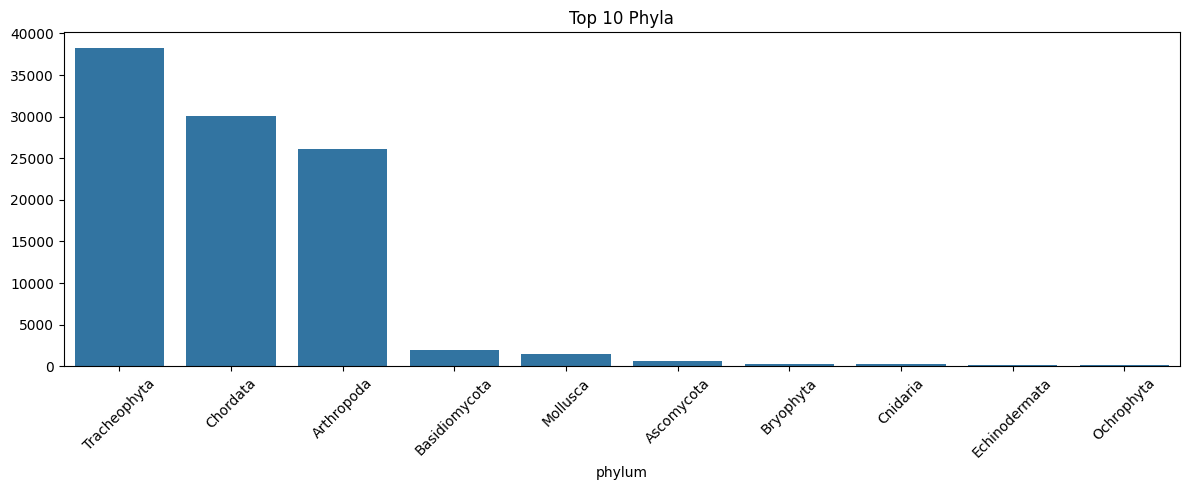

In [8]:
#Top 10 Phyla

ph = df['phylum'].value_counts().head(10)

plt.figure(figsize=(12,5))
sns.barplot(x=ph.index, y=ph.values)
plt.title("Top 10 Phyla")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("images/top_phyla.png")
plt.show()


In [23]:
# 2. Top Countries
plt.figure(figsize=(12, 6))

country_counts = df['countryCode'].value_counts().head(15)

sns.barplot(x=country_counts.index, y=country_counts.values, palette='coolwarm')
plt.title('Top 15 Countries by Observation Count')
plt.xlabel('Country Code')
plt.ylabel('Count')
plt.tight_layout()
#plt.show()
plt.savefig('images/top_countries.png')
plt.close()


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15992\3677535394.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=country_counts.index, y=country_counts.values, palette='coolwarm')


In [10]:
country_counts = df['countryCode'].value_counts()
country_counts


countryCode
US    45347
CA     8473
RU     6027
AU     4485
MX     3135
      ...  
BL        1
NE        1
CI        1
SS        1
KM        1
Name: count, Length: 223, dtype: int64

In [11]:
#Under-sampled countries:
under_sampled = country_counts[country_counts < country_counts.median()]
under_sampled


countryCode
ET    14
MQ    14
BT    14
MM    14
IQ    11
      ..
BL     1
NE     1
CI     1
SS     1
KM     1
Name: count, Length: 108, dtype: int64

In [12]:
#Compare Species Richness vs. Observation Effort
#Regions with low observations AND low species richness are likely under-sampled.
#-----------------------------------------------------------

richness = df.groupby('countryCode')['species'].nunique()
effort = df['countryCode'].value_counts()

sampling_df = pd.DataFrame({
    'richness': richness,
    'effort': effort
}).fillna(0)

under_sampled = sampling_df[(sampling_df['effort'] < sampling_df['effort'].median()) &
                            (sampling_df['richness'] < sampling_df['richness'].median())]

under_sampled


,richness,effort
countryCode,,
AD,2,2
AG,3,3
AI,2,2
AO,1,1
AQ,4,4
...,...,...
VU,2,2
WS,1,1
XK,4,4


In [24]:
# Yearly Trend
plt.figure(figsize=(12, 6))

year_counts = df['year'].value_counts().sort_index()
year_counts = year_counts[year_counts.index > 1900]

# Line plot
sns.lineplot(x=year_counts.index, y=year_counts.values, marker="o")

# Add labels only at decades
for x, y in zip(year_counts.index, year_counts.values):
    if x % 10 == 0:   # show only every 10 years
        plt.text(x, y, f"{y:,}", fontsize=9, ha='center', va='bottom')

plt.title('Observations per Year (post-1900)')
plt.xlabel('Year')
plt.ylabel('Count')
plt.grid(True)
plt.tight_layout()

#plt.show()
plt.savefig('images/yearly_trend.png')
plt.close()


In [25]:
# Latitude Distribution
plt.figure(figsize=(12, 6))

sns.histplot(df['decimalLatitude'], bins=50, kde=True)
plt.title('Distribution of Observations by Latitude')
plt.xlabel('Latitude')
plt.ylabel('Frequency')
plt.tight_layout()
#plt.show()
plt.savefig('images/latitude_distribution.png')
plt.close()


In [26]:
# COVID-19 Trend (2018–2023)
plt.figure(figsize=(12, 6))

covid_df = df[(df['year'] >= 2018) & (df['year'] <= 2023)]

if not covid_df.empty:
    year_counts = covid_df['year'].value_counts().sort_index()

    sns.lineplot(x=year_counts.index, y=year_counts.values, marker='o')

    # Add value labels on each point
    for x, y in zip(year_counts.index, year_counts.values):
        plt.text(x, y, f"{y:,}", fontsize=10, ha='center', va='bottom')

    plt.title('Biodiversity Observations during COVID-19 Era (2018–2023)')
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.axvline(x=2020, color='r', linestyle='--', label='Start of Pandemic')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    #plt.show()
    plt.savefig('images/covid_trend.png')
    plt.close()


In [16]:
animalia_df = df[df['kingdom'] == 'Animalia']
plantae_df  = df[df['kingdom'] == 'Plantae']
fungi_df    = df[df['kingdom'] == 'Fungi']


In [17]:
animalia_phylum = animalia_df['phylum'].value_counts()
plantae_phylum  = plantae_df['phylum'].value_counts()
fungi_phylum    = fungi_df['phylum'].value_counts()


In [18]:
combined = pd.DataFrame({
    "Animalia": animalia_phylum,
    "Plantae": plantae_phylum,
    "Fungi": fungi_phylum
}).fillna(0)


<Figure size 1400x800 with 0 Axes>

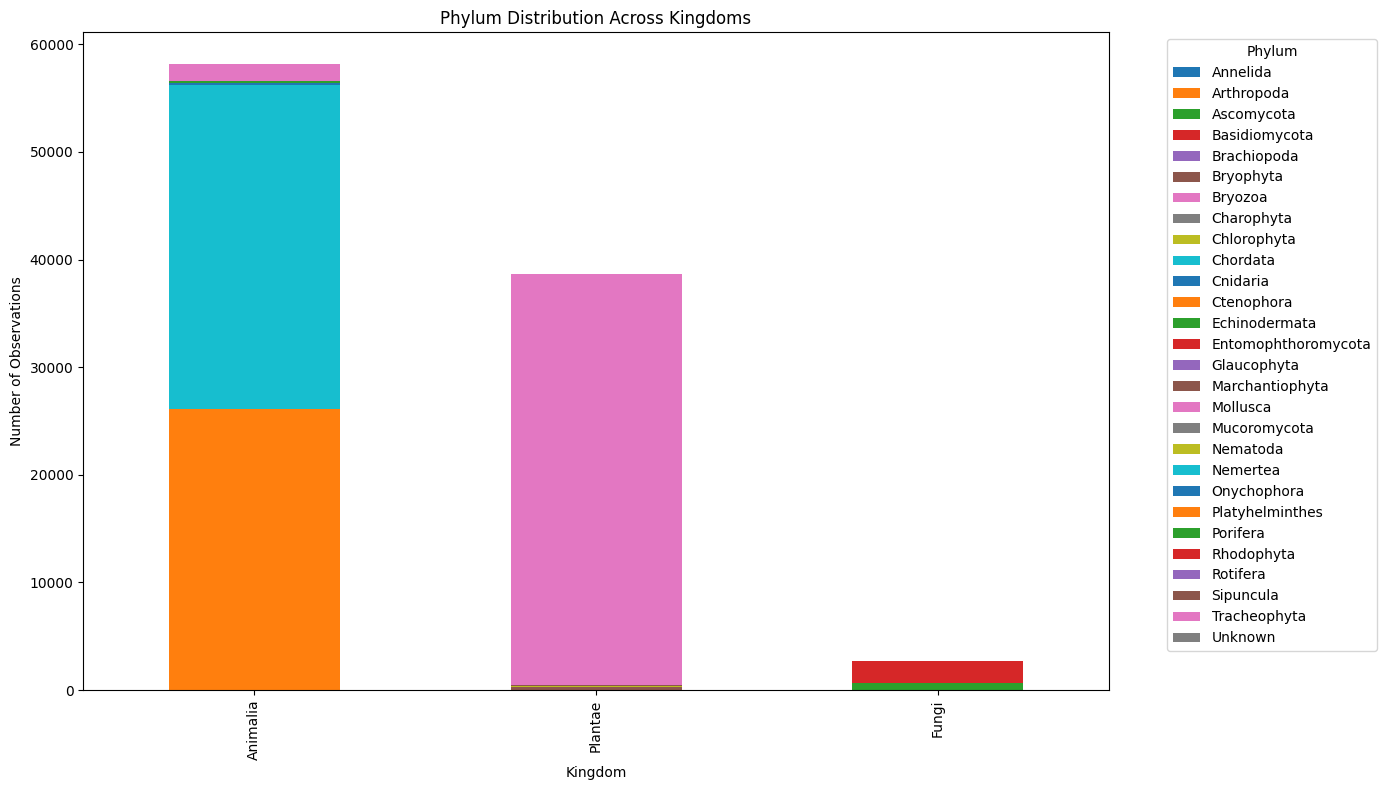

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))

combined.T.plot(kind='bar', stacked=True, figsize=(14,8))

plt.title("Phylum Distribution Across Kingdoms")
plt.xlabel("Kingdom")
plt.ylabel("Number of Observations")
plt.legend(title="Phylum", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# **Advanced Extensions**

In [20]:
##---------------------------------------
## Shannon Index
##---------------------------------------

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

def calculate_shannon_index(df):
    """Calculates Shannon Index for top 5 countries."""
    top_countries = df['countryCode'].value_counts().head(5).index.tolist()
    shannon_results = {}
    
    for country in top_countries:
        country_data = df[df['countryCode'] == country]
        species_counts = country_data['scientificName'].value_counts()
        total_individuals = species_counts.sum()
        proportions = species_counts / total_individuals
        shannon_index = -np.sum(proportions * np.log(proportions))
        shannon_results[country] = shannon_index
        
    return shannon_results

def plot_shannon_index(shannon_results):
    """Plots Shannon Index using Plotly."""
    df_shannon = pd.DataFrame(list(shannon_results.items()), columns=['Country', 'Shannon Index'])
    fig = px.bar(df_shannon, x='Country', y='Shannon Index', title='Species Richness (Shannon Index) for Top 5 Countries', color='Shannon Index', color_continuous_scale='Magma')
    return fig



In [21]:
##---------------------------------------
#Cluster Analysis
##---------------------------------------

def perform_cluster_analysis(df):
    """Performs K-Means clustering on geographical coordinates."""
    coords = df[['decimalLatitude', 'decimalLongitude']].dropna()
    
    # Sample if too large
    if len(coords) > 50000:
        coords_sample = coords.sample(50000, random_state=42)
    else:
        coords_sample = coords

    kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
    coords_sample['cluster'] = kmeans.fit_predict(coords_sample)
    
    return coords_sample, kmeans.cluster_centers_

def plot_clusters(coords_sample):
    """Plots geographical clusters using Plotly."""
    fig = px.scatter_mapbox(coords_sample, lat="decimalLatitude", lon="decimalLongitude", color="cluster",
                            zoom=1, height=600, title='Geographical Clusters of Observations (K-Means, k=5)')
    fig.update_layout(mapbox_style="open-street-map")
    return fig



In [22]:
##---------------------------------------
# Predictions
##---------------------------------------

def predict_trends(df):
    """Predicts future observation trends using Linear Regression."""
    yearly_counts = df['year'].value_counts().sort_index().reset_index()
    yearly_counts.columns = ['year', 'count']
    
    # Filter for recent relevant history (e.g., post-1950)
    model_data = yearly_counts[yearly_counts['year'] >= 1950]
    
    X = model_data[['year']]
    y = model_data['count']
    
    model = LinearRegression()
    model.fit(X, y)
    
    future_years = np.array([[2024], [2025], [2030]])
    predictions = model.predict(future_years)
    
    return model_data, future_years, predictions, model

def plot_predictions(model_data, future_years, predictions, model):
    """Plots trend predictions using Plotly."""
    X = model_data[['year']]
    
    fig = go.Figure()
    
    # Actual Data
    fig.add_trace(go.Scatter(x=model_data['year'], y=model_data['count'], mode='markers', name='Actual Data'))
    
    # Trend Line
    fig.add_trace(go.Scatter(x=model_data['year'], y=model.predict(X), mode='lines', name='Trend Line', line=dict(color='red')))
    
    # Predictions
    fig.add_trace(go.Scatter(x=future_years.flatten(), y=predictions, mode='markers', name='Predictions', marker=dict(color='green', size=10, symbol='x')))
    
    fig.update_layout(title='Observation Trend and Forecast (Linear Regression)', xaxis_title='Year', yaxis_title='Count')
    return fig
